# Estimating Outgoing Migrants

In this notebook we use sklearn regressor methods to estimate the number of outgoing migrants of a county using just the population information.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import progressbar

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time
import itertools
import scipy.stats
import scipy.spatial.distance

#These are the libraries we have developed
import Data, Figures, Models
Data = reload(Data)
Figures = reload(Figures)
Models = reload(Models)

#weird stuff
from IPython.display import HTML
from __future__ import print_function


#sklearn stuff
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RANSACRegressor, Ridge
from sklearn import cross_validation
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import sklearn.base

## Load Data

In [14]:
startYear = 2004
stopYear = 2012
yearRange = range(startYear,stopYear+1)
n = len(yearRange)

print("Loading data for years %d to %d" % (startYear, stopYear))
print("-----------------------------")
startTime = float(time.time())
populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange)
        
countyIds = Data.loadCounties()
countyIdMap = {countyId:i for i,countyId in enumerate(countyIds)}
countyIndexMap = {i:countyId for i,countyId in enumerate(countyIds)}
countyNameMapping = Data.loadCountyNameMap()

distanceMatrix = Data.loadCountyPairwiseDistanceMatrix()
#radialPopulationSums = Data.loadCircleSums()

print("Finished loading data in %0.4f seconds" % (time.time()-startTime))

Loading data for years 2004 to 2012
-----------------------------
Loading the distance matrix
Finished loading data in 37.4699 seconds


## Setup Data into X, y format

- X is a vector of population data over all datasets (concatenating everything together)
- y is a vector of the number of outgoing migrants (what we want to predict) for the corresponding county from X (i.e. $X_i$ is the population of county $i$ and $y_i$ is its sum of outgoing migrants)

In [3]:
X = [] #county populations
y = [] #number of outgoing migrants

for i,year in enumerate(yearRange):
    for j,countyId in enumerate(countyIds):
        X.append(populationDataSets[i][j])
        y.append(np.sum(migrationDataSets[i][j,:]))

assert len(X) == len(y)

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0],1)
#y = y.reshape(y.shape[0],1)

X_ = X.copy()

print("Loaded %d entries" % (len(X)))

Loaded 28287 entries


## Add Quadratic Features

Optionally, here we can add quadratic features to the input data. Each value in $X$ will be split into 3 values: $1$, $X_i$, $X_i^2$.

In [4]:
# We can use polynomial features to get a quadratic fitting, but it isn't good
if False:
    poly = PolynomialFeatures(degree=2)
    X = poly.fit_transform(X)

## Setup ML problem

Create list of regression models and metrics we want to use.

In [35]:
regressors = [
    LinearRegression(),
    RANSACRegressor(),
    GradientBoostingRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5),
    DecisionTreeRegressor(max_depth=4),
    DecisionTreeRegressor(max_depth=5),
    DecisionTreeRegressor(max_depth=6),
    DecisionTreeRegressor(max_depth=7),
    ExtraTreeRegressor(max_depth=4),
    ExtraTreeRegressor(max_depth=5),
    ExtraTreeRegressor(max_depth=6),
    ExtraTreeRegressor(max_depth=7)
]


regressorNames = [
    "Linear Regression",
    "RANSACRegressor",
    "GradientBoostingRegressor, Max Depth 7",
    "RandomForestRegressor, Max Depth 7",
    "DecisionTreeRegressor, Max Depth 7",
    "DecisionTreeRegressor, Max Depth 8",
    "DecisionTreeRegressor, Max Depth 9",
    "DecisionTreeRegressor, Max Depth 10",
    "ExtraTreeRegressor, Max Depth 7",
    "ExtraTreeRegressor, Max Depth 8",
    "ExtraTreeRegressor, Max Depth 9",
    "ExtraTreeRegressor, Max Depth 10"
]
'''
regressorNames = [
    _.__class__.__name__
    for _ in classifiers
]
'''
#---------------------------------------------------

metrics = [
    mean_absolute_error,
    median_absolute_error,
    r2_score
]

metricNames = [
    _.__name__
    for _ in metrics
]

#---------------------------------------------------

print("Using the following regressors:")
print(regressorNames)
print("")
print("Using the following metrics:")
print(metricNames)

Using the following regressors:
['Linear Regression', 'RANSACRegressor', 'GradientBoostingRegressor, Max Depth 7', 'RandomForestRegressor, Max Depth 7', 'DecisionTreeRegressor, Max Depth 7', 'DecisionTreeRegressor, Max Depth 8', 'DecisionTreeRegressor, Max Depth 9', 'DecisionTreeRegressor, Max Depth 10', 'ExtraTreeRegressor, Max Depth 7', 'ExtraTreeRegressor, Max Depth 8', 'ExtraTreeRegressor, Max Depth 9', 'ExtraTreeRegressor, Max Depth 10']

Using the following metrics:
['mean_absolute_error', 'median_absolute_error', 'r2_score']


## Run Experiments

- Run entire experiment `numberOfExperiments` times
- For each run:
    - create a training/testing split randomly
    - train each model from previous step on training split
    - test on testing split and record metrics using all metrics from previous step
- Average results over all experimental runs


In [45]:
numberOfExperiments = 50
startTime = float(time.time())

results = [] # [k][i][j] is the results on the the jth metric for the ith regressor in the kth experiment run
for i in range(numberOfExperiments):
    print("Running experiment %d out of %d" % (i+1, numberOfExperiments))
    
    regressorScores = [] # [i][j] is the jth metric result for the ith regressor
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)
    
    for regressor,regressorName in zip(regressors,regressorNames):
        #print("\tTraining regressor: %s ... " % (regressorName), end="")
        regressorStartTime = float(time.time())
        
        regressor = sklearn.base.clone(regressor)
        
        regressor.fit(X_train,y_train)
        predicted = regressor.predict(X_test)
        predicted[predicted<0] = 0
        
        scores = []
        for metric in metrics:
            score = metric(y_test,predicted)
            scores.append(score)
            
        regressorScores.append(scores)
        
        #print("Finished in %0.2f seconds" % (time.time()-regressorStartTime))
        
    results.append(regressorScores)

results = np.array(results)

print("Finished running %d experiments in %0.4f seconds" % (numberOfExperiments, time.time()-startTime))

Running experiment 1 out of 50
Running experiment 2 out of 50
Running experiment 3 out of 50
Running experiment 4 out of 50
Running experiment 5 out of 50
Running experiment 6 out of 50
Running experiment 7 out of 50
Running experiment 8 out of 50
Running experiment 9 out of 50
Running experiment 10 out of 50
Running experiment 11 out of 50
Running experiment 12 out of 50
Running experiment 13 out of 50
Running experiment 14 out of 50
Running experiment 15 out of 50
Running experiment 16 out of 50
Running experiment 17 out of 50
Running experiment 18 out of 50
Running experiment 19 out of 50
Running experiment 20 out of 50
Running experiment 21 out of 50
Running experiment 22 out of 50
Running experiment 23 out of 50
Running experiment 24 out of 50
Running experiment 25 out of 50
Running experiment 26 out of 50
Running experiment 27 out of 50
Running experiment 28 out of 50
Running experiment 29 out of 50
Running experiment 30 out of 50
Running experiment 31 out of 50
Running experimen

## Output Processing

Take averages and standard deviations, import into pandas dataframe

In [46]:
#take the average and standard deviations over all the experimental runs
means = results.mean(axis=0)
stds  = results.std(axis=0)

print("Sanity Check")
print("------------------------")
print("Results shape: %s" % (str(results.shape)))
print("Shape of means: %s" % (str(means.shape)))
print("Shape of stds : %s" % (str(stds.shape)))
print("")
print("Creating the result DataFrames")
print("------------------------")
df_means = pd.DataFrame(means, index=regressorNames, columns=metricNames)
df_stds  = pd.DataFrame(stds , index=regressorNames, columns=metricNames)

Sanity Check
------------------------
Results shape: (50, 12, 3)
Shape of means: (12, 3)
Shape of stds : (12, 3)

Creating the result DataFrames
------------------------


In [47]:
HTML(df_means.to_html())

In [48]:
HTML(df_stds.to_html())

In [49]:
# combine table values into single table with STD represented as +/-
combined_df_data = []
for metricName in metricNames:
    tempData = []
    for regressorName in regressorNames:
        tempData.append("%0.4f +/- %0.2f" % (df_means[metricName][regressorName], df_stds[metricName][regressorName]))
    combined_df_data.append(tempData)

combined_df_data = np.array(combined_df_data)
combinedDf = pd.DataFrame(combined_df_data.T, index=regressorNames, columns=metricNames)

In [50]:
HTML(combinedDf.to_html())

## Plot Learned Function Shapes

- The first cell makes all plots on a single image, the second cell makes each plot individually.
- This is just to give a general idea of the function behaviour

Visualizing regressor: Linear Regression ... 
---------------------------------
Visualizing regressor: RANSACRegressor ... 
---------------------------------
Contains negative predictions
Visualizing regressor: GradientBoostingRegressor, Max Depth 7 ... 
---------------------------------
Visualizing regressor: RandomForestRegressor, Max Depth 7 ... 
---------------------------------
Visualizing regressor: DecisionTreeRegressor, Max Depth 7 ... 
---------------------------------
Visualizing regressor: DecisionTreeRegressor, Max Depth 8 ... 
---------------------------------
Visualizing regressor: DecisionTreeRegressor, Max Depth 9 ... 
---------------------------------
Visualizing regressor: DecisionTreeRegressor, Max Depth 10 ... 
---------------------------------
Visualizing regressor: ExtraTreeRegressor, Max Depth 7 ... 
---------------------------------
Visualizing regressor: ExtraTreeRegressor, Max Depth 8 ... 
---------------------------------
Visualizing regressor: ExtraTreeRegre

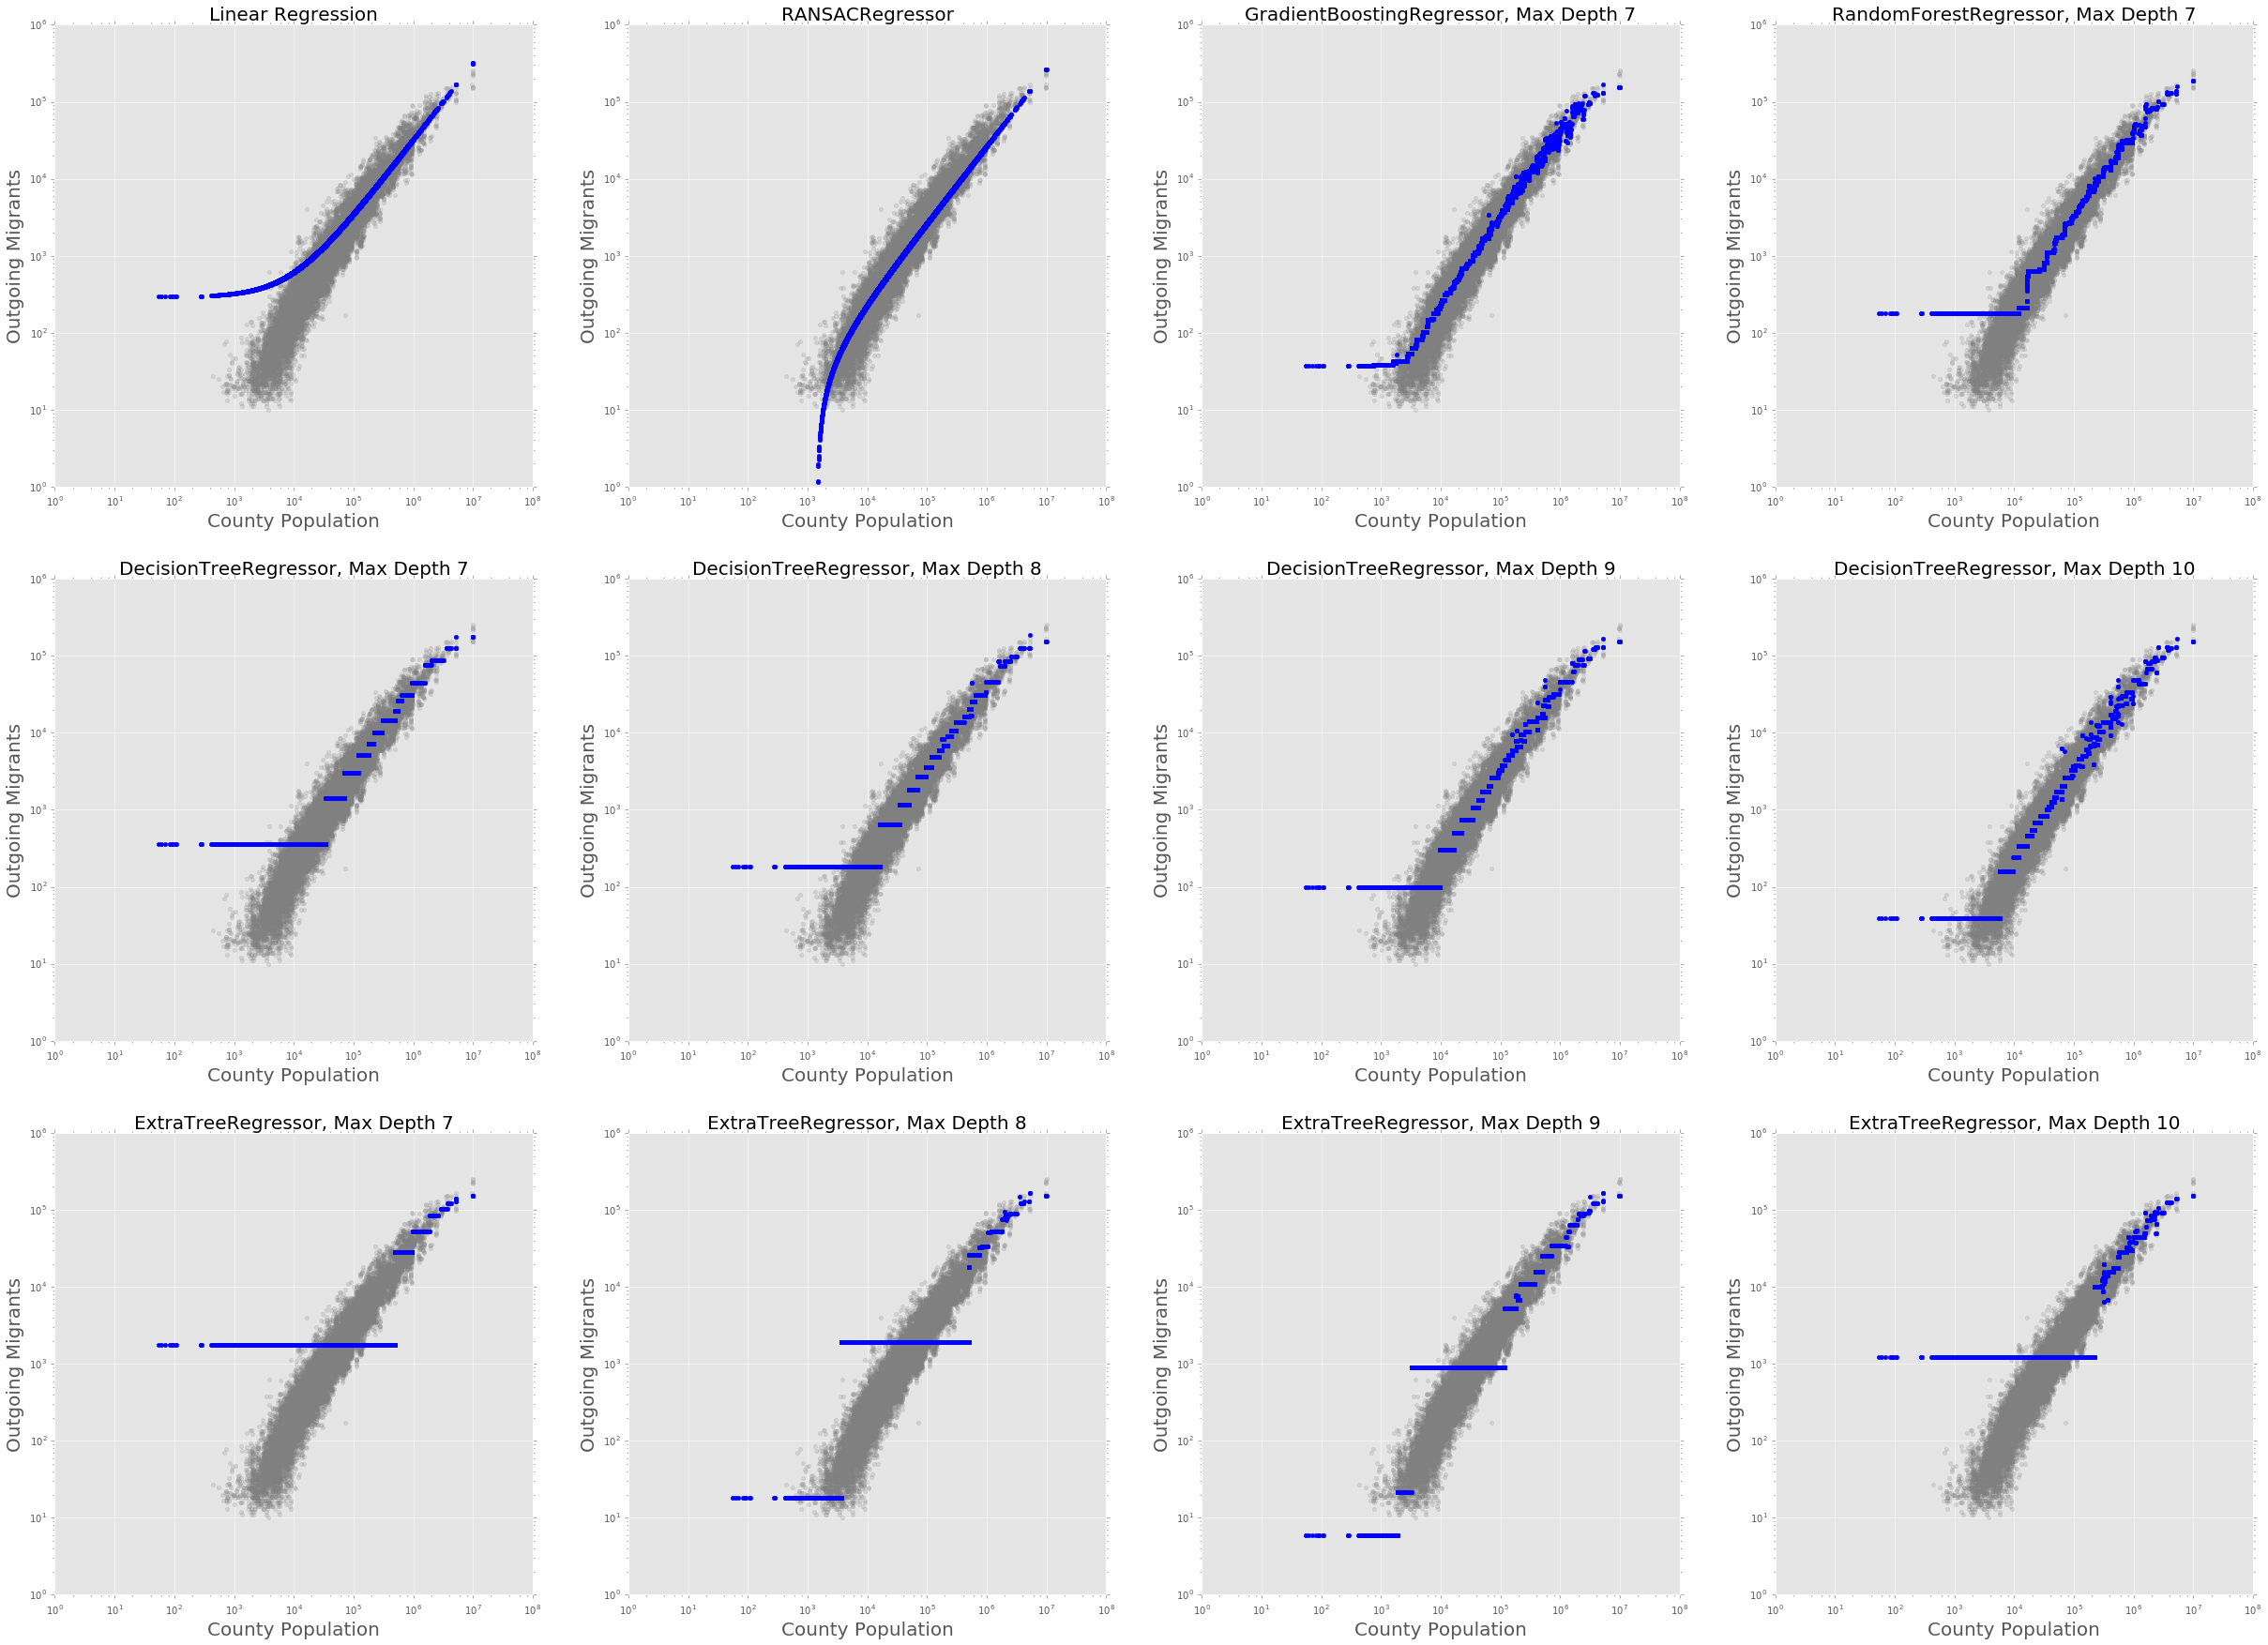

In [51]:
fig, axs = plt.subplots(3,4, figsize=(42, 30), facecolor='w', edgecolor='k')
axs = axs.ravel()

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

for i,(regressor,regressorName) in enumerate(zip(regressors,regressorNames)):
    print("Visualizing regressor: %s ... " % (regressorName))
    print("---------------------------------")

    regressor = sklearn.base.clone(regressor)

    regressor.fit(X_train,y_train)
    predicted = regressor.predict(X_test)
    
    predicted = predicted.reshape(predicted.shape[0],1)
    
    if np.any(predicted < 0):
        print("Contains negative predictions")
        predicted[predicted<0] = 0
        
    axs[i].scatter(X_[:,0],y[:], color='grey', label="Actual", alpha=0.2)
    if X_test.shape[1]>1:
        axs[i].scatter(X_test[:,1],predicted[:,0], color='b', label="Predicted")
    else:
        axs[i].scatter(X_test[:,0],predicted[:,0], color='b', label="Predicted")
        
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
    axs[i].set_xlim([1,1e8])
    axs[i].set_ylim([1,1e6])
    
    axs[i].set_title("%s" % (regressorName), fontsize=20)
    axs[i].set_xlabel("County Population", fontsize=20)
    axs[i].set_ylabel("Outgoing Migrants", fontsize=20)

fig.show()

Visualizing regressor: Linear Regression ... 
---------------------------------


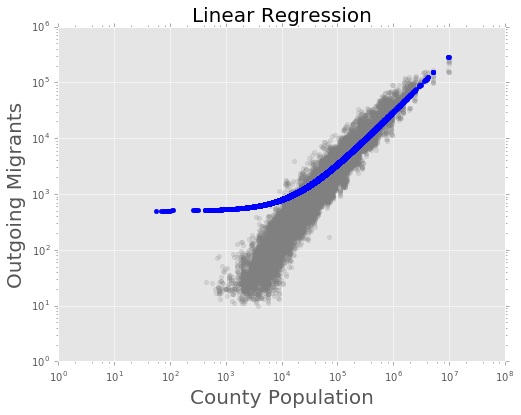

Visualizing regressor: RANSACRegressor ... 
---------------------------------


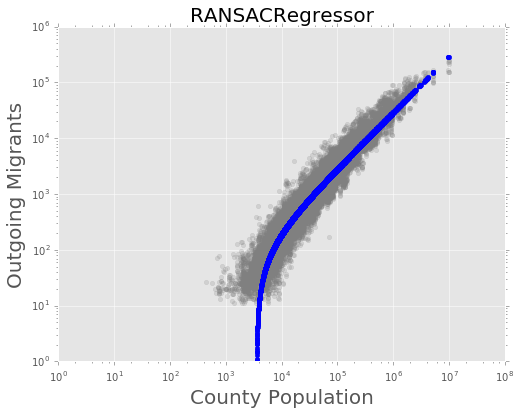

Visualizing regressor: GradientBoostingRegressor, Max Depth 7 ... 
---------------------------------


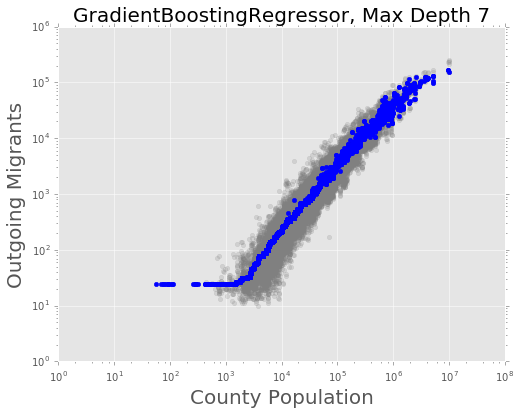

Visualizing regressor: RandomForestRegressor, Max Depth 7 ... 
---------------------------------


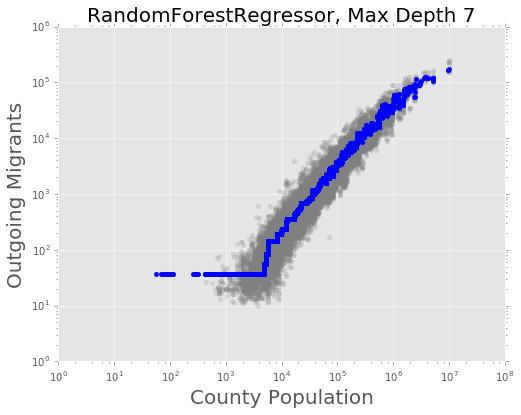

Visualizing regressor: DecisionTreeRegressor, Max Depth 7 ... 
---------------------------------


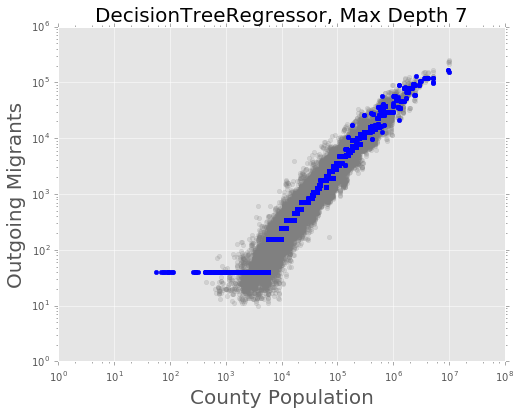

Visualizing regressor: DecisionTreeRegressor, Max Depth 8 ... 
---------------------------------


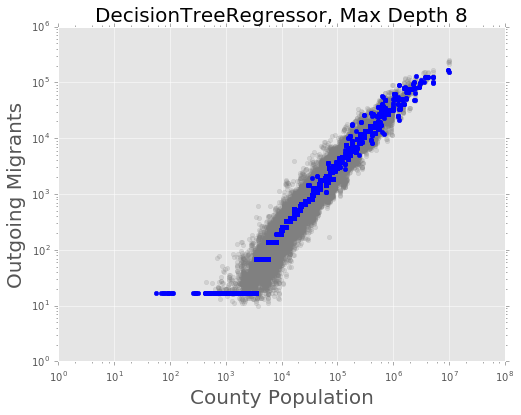

Visualizing regressor: DecisionTreeRegressor, Max Depth 9 ... 
---------------------------------


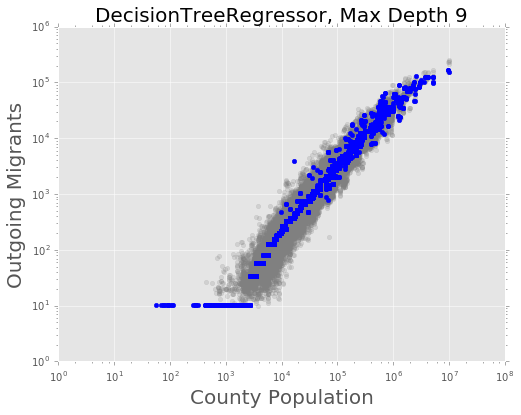

Visualizing regressor: DecisionTreeRegressor, Max Depth 10 ... 
---------------------------------


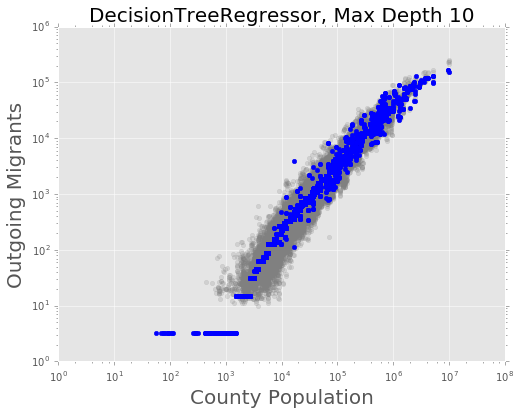

Visualizing regressor: ExtraTreeRegressor, Max Depth 7 ... 
---------------------------------


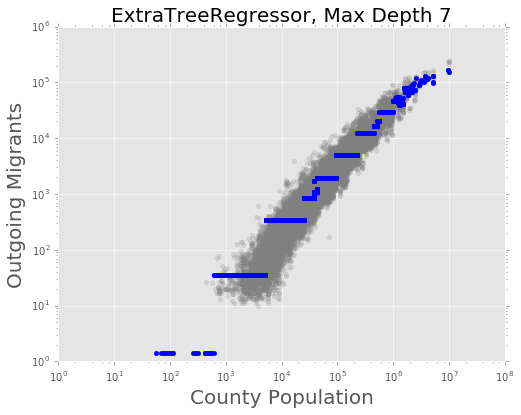

Visualizing regressor: ExtraTreeRegressor, Max Depth 8 ... 
---------------------------------


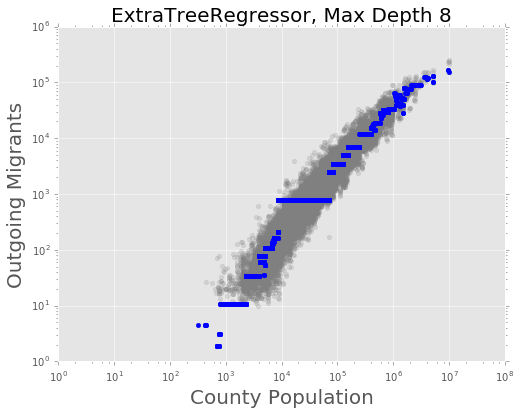

Visualizing regressor: ExtraTreeRegressor, Max Depth 9 ... 
---------------------------------


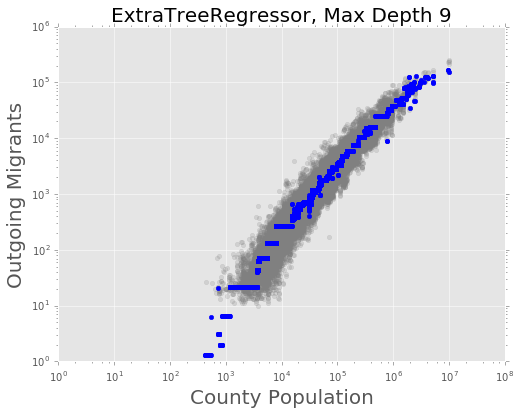

Visualizing regressor: ExtraTreeRegressor, Max Depth 10 ... 
---------------------------------


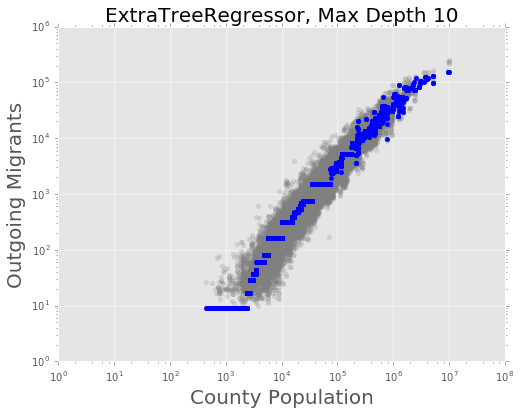

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

for i,(regressor,regressorName) in enumerate(zip(regressors,regressorNames)):
    print("Visualizing regressor: %s ... " % (regressorName))
    print("---------------------------------")

    regressor = sklearn.base.clone(regressor)

    regressor.fit(X_train,y_train)
    predicted = regressor.predict(X_test)
    
    predicted = predicted.reshape(predicted.shape[0],1)
    
    plt.figure(figsize=(8,6))
    
    plt.scatter(X_[:,0],y[:], color='grey', label="Actual", alpha=0.2)
    if X_test.shape[1]>1:
        plt.scatter(X_test[:,1],predicted[:,0], color='b', label="Predicted")
    else:
        plt.scatter(X_test[:,0],predicted[:,0], color='b', label="Predicted")
        
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim([1,1e8])
    plt.ylim([1,1e6])
    
    plt.title("%s" % (regressorName), fontsize=20)
    plt.xlabel("County Population", fontsize=20)
    plt.ylabel("Outgoing Migrants", fontsize=20)
    plt.show()
    
